In [2]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
from torchvision import datasets, models
from torch.utils.data import DataLoader
import copy
import math
import cv2
import albumentations as A  # data augmentation library
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

In [3]:
from tqdm import tqdm
import warnings

In [4]:
# remove warnings (optional)
warnings.filterwarnings("ignore")

In [5]:
# Set the device to CPU
device = torch.device("cpu")

In [6]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are required for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split  # train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))  # annotations stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]  # Required annotation format for albumentations

        # Apply transformations if available
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
            image = transformed['image']
            boxes = transformed['bboxes']

        # Convert from xywh to xyxy format for bounding boxes
        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        # Create target dictionary for bounding boxes, labels, etc.
        targ = {
        'boxes': boxes,
        'labels': torch.tensor([t['category_id'] - 1 for t in target], dtype=torch.int64),  # Adjust here
        'image_id': torch.tensor([id]),
        'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
        'iscrowd': torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        }

        # Convert the image to a PyTorch tensor if it's still a NumPy array
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        # Normalize the image by dividing by 255
        image = image.float().div(255)
        return image, targ

    def __len__(self):
        return len(self.ids)

In [7]:
def get_transforms(train=False):
    if train:
        return A.Compose([
            A.Resize(600, 600),  # Resize all images to 600x600
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        return A.Compose([
            A.Resize(600, 600),  # Resize all images to 600x600 during validation/testing as well
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))

In [8]:
# Update dataset paths
dataset_path = '/content/drive/MyDrive/Aquarium Combined.v2-raw-1024.coco-mmdetection'

In [9]:
# Load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
classes = [i[1]['name'] for i in categories.items()]

loading annotations into memory...
Done (t=2.09s)
creating index...
index created!


In [10]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [11]:
test_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [12]:
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

In [13]:
def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

In [14]:
# Create the dataset and DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn  # Use the custom collate function here
)

# For testing
test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    num_workers=0,
    collate_fn=collate_fn
)

In [15]:
# Reduce batch size and number of workers for CPU execution
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)

In [16]:
for images, targets in tqdm(train_loader):
    # Check what 'targets' contains before accessing it
    print(f"Targets: {targets}")

    # Assuming targets should be a list of dictionaries
    if len(targets) > 0:
        print(f"Target keys: {targets[0].keys()}")  # Check what keys are in the target dictionary
        print(f"Target boxes shape: {targets[0].get('boxes', 'No boxes')}")  # Check if 'boxes' exist

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    break  # Stop after one batch to avoid excessive output

  0%|          | 0/224 [00:00<?, ?it/s]

Targets: [{'boxes': tensor([[125.7812, 336.3281, 232.0312, 380.2734],
        [ 36.7188,  39.8438,  90.6250,  76.1719],
        [ 81.2500,  67.3828, 131.2500, 101.3672],
        [142.9688,  82.6172, 187.5000, 115.4297],
        [ 40.6250,  11.7188, 116.4062,  43.9453],
        [  0.0000,  82.0312,  61.7188, 114.8438],
        [  0.0000,  31.6406,  35.1562,  63.2812],
        [428.9062, 292.9688, 527.3438, 322.2656],
        [232.8125, 117.7734, 289.0625, 145.8984],
        [114.8438,  36.3281, 167.1875,  64.4531],
        [  0.0000, 122.4609,  89.0625, 151.1719],
        [464.8438,  87.8906, 525.0000, 114.2578],
        [179.6875,  65.0391, 212.5000,  90.8203],
        [138.2812,  58.0078, 179.6875,  81.4453],
        [355.4688, 182.2266, 409.3750, 205.6641],
        [282.8125,  87.8906, 329.6875, 110.7422],
        [196.0938,  98.4375, 229.6875, 120.1172],
        [426.5625, 148.8281, 476.5625, 169.3359],
        [418.7500, 102.5391, 453.9062, 123.0469],
        [300.7812, 135.9375, 3

In [17]:
# Load the model and modify the head for the number of classes
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 131MB/s]


In [18]:
# Move the model to CPU
model = model.to(device)

In [19]:
# Define optimizer
optimizer = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.001, momentum=0.9)

In [20]:
# Training function
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.train()
    all_losses = []

    for images, targets in tqdm(loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        all_losses.append(losses.item())

    print(f"Epoch {epoch} - Loss: {np.mean(all_losses):.4f}")

In [21]:
n_classes = 7  # Number of classes in your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [22]:
# Train the model for a few epochs
num_epochs = 5
model_save_path = "/content/Aquariam.h"
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 224/224 [23:13<00:00,  6.22s/it]


Epoch 0 - Loss: 0.7976


100%|██████████| 224/224 [20:29<00:00,  5.49s/it]


Epoch 1 - Loss: 0.6354


100%|██████████| 224/224 [20:22<00:00,  5.46s/it]


Epoch 2 - Loss: 0.5322


100%|██████████| 224/224 [19:49<00:00,  5.31s/it]


Epoch 3 - Loss: 0.4977


100%|██████████| 224/224 [19:50<00:00,  5.31s/it]

Epoch 4 - Loss: 0.4565


In [23]:
# Save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/Aquariam.h


In [30]:
# Load the saved model for prediction
from torchvision import models

# Define the number of classes (7 for your case, including background class)
num_classes = 7  # 6 classes + background

# Load the pre-trained model but modify the classifier (box predictor)
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=False)  # pretrained=False since we will load our own weights

# Update the classifier (box predictor) to match the number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features  # Get the number of input features for the classifier
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)  # Re-define box_predictor with num_classes

# Load your trained weights
model.load_state_dict(torch.load(model_save_path))

# Move the model to the correct device (CPU/GPU)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [41]:
# Test prediction (on CPU)
model.eval()
img, _ = test_dataset[3]
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

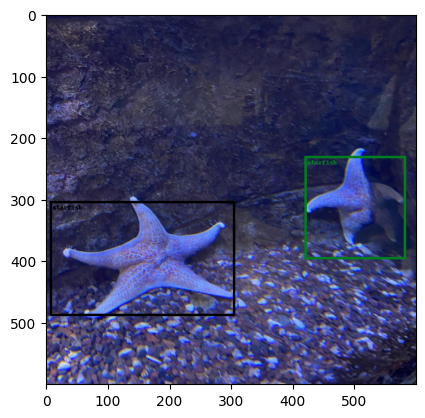

In [42]:
img_int = torch.tensor(img*255, dtype=torch.uint8)
# Draw bounding boxes on the image
plt.imshow(
    draw_bounding_boxes(
        img_int,
        pred['boxes'][pred['scores'] > 0.8],  # Filter boxes with score > 0.8
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()],  # Filter labels with score > 0.8
        width=4
    ).permute(1, 2, 0)
)
plt.show()